In [1]:
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt
import seaborn as sns

import imblearn

from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report


import xgboost as xgb

In [2]:
### download the db from link in readme
db_path = "../../dbs/delays.db"

In [3]:
def evaluate_model(model, X_test, y_test):
    
    model_acc = model.score(X_test, y_test)
    print("Test Accuracy: {:.2f}%".format(model_acc * 100))
    
    y_true = np.array(y_test)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_true, y_pred)
    clr = classification_report(y_true, y_pred, target_names=["Not Delayed", "Delayed"])
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.yticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

In [4]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        connection.text_factory = str
    except Error as e:
        print("Error occurred: " + str(e))
    return connection


def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        if query == "":
            return "Query Blank"
        else:
            df = pd.read_sql_query(query, connection)
            return df
    except Error as e:
        return "Error occurred: " + str(e)

In [5]:
sample_query = \
    """
    select 
     *
    from 
      delay
    where Year = 2015
    and Month = 1
    """

connection = create_connection(db_path)
my =  execute_query(connection, sample_query)

In [6]:
my

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,...,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2015,1,1,1,4,2015-01-01,19805,AA,N787AA,1,...,390,402,378,1,2475,0,0,0,0,0
1,2015,1,1,2,5,2015-01-02,19805,AA,N795AA,1,...,390,381,357,1,2475,0,0,0,0,0
2,2015,1,1,3,6,2015-01-03,19805,AA,N788AA,1,...,390,358,330,1,2475,0,0,0,0,0
3,2015,1,1,4,7,2015-01-04,19805,AA,N791AA,1,...,390,385,352,1,2475,0,0,0,0,0
4,2015,1,1,5,1,2015-01-05,19805,AA,N783AA,1,...,390,389,338,1,2475,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469963,2015,1,1,28,3,2015-01-28,20416,NK,N524NK,188,...,83,82,64,1,407,0,0,0,0,0
469964,2015,1,1,29,4,2015-01-29,20416,NK,N502NK,188,...,83,82,64,1,407,0,0,0,0,0
469965,2015,1,1,30,5,2015-01-30,20416,NK,N519NK,188,...,83,89,66,1,407,0,0,0,0,0
469966,2015,1,1,31,6,2015-01-31,20416,NK,N502NK,188,...,83,95,69,1,407,0,0,0,0,0


In [7]:
Flights = pd.read_csv('../../datasets/flights.csv')

/Users/ayushsubedi/Desktop/learn/fp/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
Flights = Flights.iloc[:,:23]
Flights.dropna(inplace=True)
Flights = Flights[Flights["MONTH"]==1]

In [9]:
Flights

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469963,2015,1,31,6,B6,839,N658JB,JFK,BQN,2359,...,17.0,221.0,200.0,179.0,1576,416.0,3.0,440,419.0,-21.0
469964,2015,1,31,6,DL,1887,N855NW,SEA,DTW,2359,...,15.0,252.0,239.0,209.0,1927,644.0,14.0,711,658.0,-13.0
469965,2015,1,31,6,F9,300,N218FR,DEN,TPA,2359,...,37.0,192.0,212.0,168.0,1506,525.0,9.0,511,534.0,23.0
469966,2015,1,31,6,F9,422,N954FR,DEN,ATL,2359,...,39.0,162.0,191.0,141.0,1199,500.0,10.0,441,510.0,29.0


In [10]:
his = Flights.copy()

In [11]:
cols = ['Month',
 'DayofMonth',
 'DayOfWeek',
 'IATA_CODE_Reporting_Airline',
 'OriginAirportID',
 'DestAirportID',
 'AirTime',
 'ArrDelay',
 'DepDelay']

In [12]:
his.rename({
     'YEAR': 'Year',
     'MONTH': 'Month',
     'AIRLINE' : 'IATA_CODE_Reporting_Airline',
     'DAY': 'DayofMonth',
     'DAY_OF_WEEK': 'DayOfWeek',
     'ORIGIN_AIRPORT': 'OriginAirportID',
     'DESTINATION_AIRPORT': 'DestAirportID',
     'DEPARTURE_DELAY' : 'DepDelay',
     'AIR_TIME': 'AirTime',
     'ARRIVAL_DELAY' : 'ArrDelay'
}, axis=1
, inplace=True)

In [13]:
his

,Year,Month,DayofMonth,DayOfWeek,IATA_CODE_Reporting_Airline,FLIGHT_NUMBER,TAIL_NUMBER,OriginAirportID,DestAirportID,SCHEDULED_DEPARTURE,...,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AirTime,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ArrDelay
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469963,2015,1,31,6,B6,839,N658JB,JFK,BQN,2359,...,17.0,221.0,200.0,179.0,1576,416.0,3.0,440,419.0,-21.0
469964,2015,1,31,6,DL,1887,N855NW,SEA,DTW,2359,...,15.0,252.0,239.0,209.0,1927,644.0,14.0,711,658.0,-13.0
469965,2015,1,31,6,F9,300,N218FR,DEN,TPA,2359,...,37.0,192.0,212.0,168.0,1506,525.0,9.0,511,534.0,23.0
469966,2015,1,31,6,F9,422,N954FR,DEN,ATL,2359,...,39.0,162.0,191.0,141.0,1199,500.0,10.0,441,510.0,29.0


In [14]:
def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [15]:
def preprocess_inputs(df):
    df = df.copy()
    
    y = (df.ArrDelay>15).astype(int)
    
    df = df.drop('ArrDelay', axis=1)
    
    # One-hot encode nominal feature columns
    X = onehot_encode(
        df,
        column_dict={
            'IATA_CODE_Reporting_Airline': 'AL',
            'OriginAirportID': 'OA',
            'DestAirportID': 'DA',
            'Month': 'M',
            'DayofMonth': 'DM',
            'DayOfWeek': 'DW',
   
        }
    )
    
 
    
    smote = SMOTE()
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    # Todo: only apply this to columns that need it    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
   
    return X_train, X_test, y_train, y_test
    

In [16]:
X_train, X_test, y_train, y_test = preprocess_inputs(my[cols])

In [17]:
clf_rf = RandomForestClassifier(n_estimators = 100, verbose=1, n_jobs=-1) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Test Accuracy: 75.70%


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


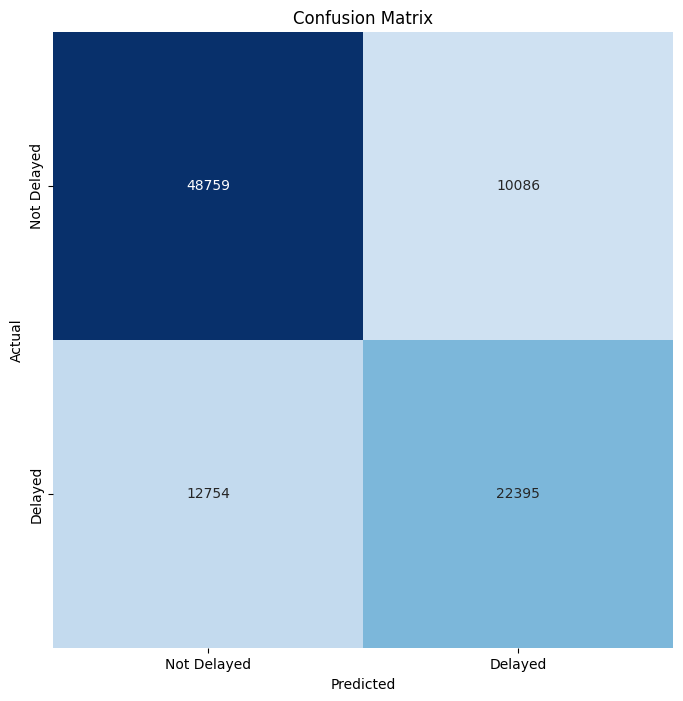

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.79      0.83      0.81     58845
     Delayed       0.69      0.64      0.66     35149

    accuracy                           0.76     93994
   macro avg       0.74      0.73      0.74     93994
weighted avg       0.75      0.76      0.75     93994



In [18]:
evaluate_model(clf_rf, X_test, y_test)

In [19]:
X_train, X_test, y_train, y_test = preprocess_inputs(his[cols])

In [20]:
X_train

,AirTime,DepDelay,AL_AA,AL_AS,AL_B6,AL_DL,AL_EV,AL_F9,AL_HA,AL_MQ,...,DM_29,DM_30,DM_31,DW_1,DW_2,DW_3,DW_4,DW_5,DW_6,DW_7
0,-0.905793,0.103740,-0.282307,-0.138888,-0.184295,-0.328577,-0.304271,-0.10159,-0.101917,-0.24423,...,-0.153324,-0.159328,-0.13029,-0.363641,-0.329368,-0.335624,-0.388903,-0.413973,-0.352716,2.794806
1,-1.058774,0.180614,-0.282307,-0.138888,-0.184295,-0.328577,-0.304271,-0.10159,-0.101917,-0.24423,...,-0.153324,-0.159328,-0.13029,-0.363641,3.036117,-0.335624,-0.388903,-0.413973,-0.352716,-0.357807
2,1.903487,-0.530464,-0.282307,-0.138888,-0.184295,-0.328577,-0.304271,-0.10159,-0.101917,-0.24423,...,-0.153324,-0.159328,-0.13029,-0.363641,-0.329368,-0.335624,2.571334,-0.413973,-0.352716,-0.357807
3,0.109442,-0.492027,-0.282307,-0.138888,-0.184295,3.043423,-0.304271,-0.10159,-0.101917,-0.24423,...,-0.153324,-0.159328,-0.13029,-0.363641,-0.329368,-0.335624,-0.388903,-0.413973,-0.352716,2.794806
4,-0.613739,-0.357499,-0.282307,-0.138888,-0.184295,3.043423,-0.304271,-0.10159,-0.101917,-0.24423,...,-0.153324,-0.159328,-0.13029,-0.363641,-0.329368,-0.335624,-0.388903,-0.413973,-0.352716,2.794806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583147,-0.891886,1.256838,-0.282307,-0.138888,-0.184295,-0.328577,-0.304271,-0.10159,-0.101917,-0.24423,...,-0.153324,-0.159328,-0.13029,-0.363641,-0.329368,-0.335624,-0.388903,-0.413973,-0.352716,-0.357807
583148,-0.975330,0.607597,-0.282307,-0.138888,-0.184295,-0.328577,-0.304271,-0.10159,-0.101917,-0.24423,...,-0.153324,-0.159328,-0.13029,-0.363641,-0.329368,-0.335624,-0.388903,2.415616,-0.352716,-0.357807
583149,0.262423,0.339449,-0.282307,-0.138888,-0.184295,-0.328577,-0.304271,-0.10159,-0.101917,-0.24423,...,-0.153324,-0.159328,-0.13029,-0.363641,-0.329368,-0.335624,-0.388903,-0.413973,-0.352716,-0.357807
583150,3.360638,0.224020,-0.282307,-0.138888,-0.184295,-0.328577,-0.304271,-0.10159,-0.101917,-0.24423,...,-0.153324,-0.159328,-0.13029,-0.363641,-0.329368,-0.335624,-0.388903,-0.413973,-0.352716,-0.357807


In [21]:
clf_rf = RandomForestClassifier(n_estimators = 100, verbose=1, n_jobs=-1) 
clf_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


Test Accuracy: 92.39%


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


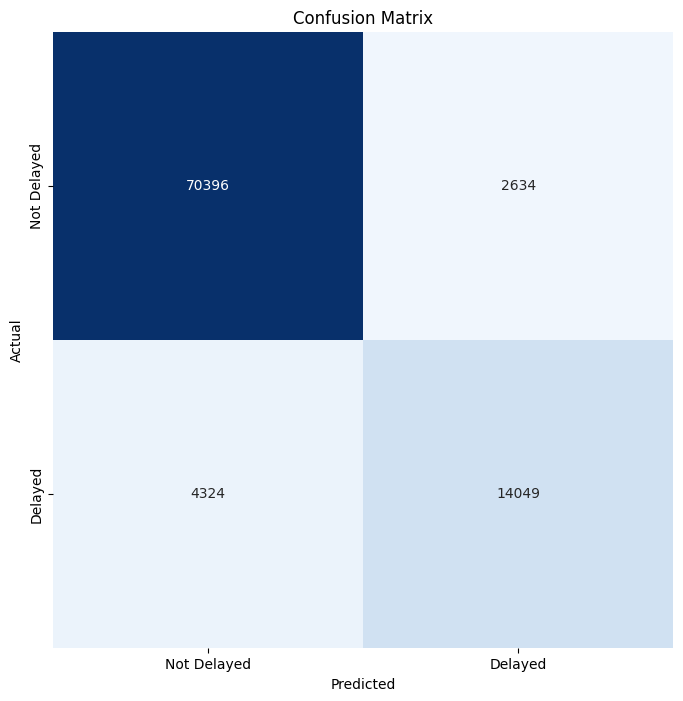

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.94      0.96      0.95     73030
     Delayed       0.84      0.76      0.80     18373

    accuracy                           0.92     91403
   macro avg       0.89      0.86      0.88     91403
weighted avg       0.92      0.92      0.92     91403



In [22]:
evaluate_model(clf_rf, X_test, y_test)